In [11]:
from typing import Optional, List
import io
import fitz
from pathlib import Path

from PIL import Image
from transformers import AutoProcessor, VisionEncoderDecoderModel
import torch

from transformers import StoppingCriteria, StoppingCriteriaList
from collections import defaultdict

In [12]:
# Select Nougat model
processor = AutoProcessor.from_pretrained("facebook/nougat-small")
model = VisionEncoderDecoderModel.from_pretrained("facebook/nougat-small")

In [4]:
def rasterize_paper(pdf: Path, outpath: Optional[Path] = None, dpi: int = 96, return_pil=False, pages=None,) -> Optional[List[io.BytesIO]]:
    pillow_images = []
    if outpath is None:
        return_pil = True
    try:
        if isinstance(pdf, (str, Path)):
            pdf = fitz.open(pdf)
        if pages is None:
            pages = range(len(pdf))
        for i in pages:
            page_bytes: bytes = pdf[i].get_pixmap(dpi=dpi).pil_tobytes(format="PNG")
            if return_pil:
                pillow_images.append(io.BytesIO(page_bytes))
            else:
                with (outpath / ("%02d.png" % (i + 1))).open("wb") as f:
                    f.write(page_bytes)
    except Exception:
        pass
    if return_pil:
        return pillow_images


In [13]:
class RunningVarTorch:
    def __init__(self, L=15, norm=False):
        self.values = None
        self.L = L
        self.norm = norm

    def push(self, x: torch.Tensor):
        assert x.dim() == 1
        if self.values is None:
            self.values = x[:, None]
        elif self.values.shape[1] < self.L:
            self.values = torch.cat((self.values, x[:, None]), 1)
        else:
            self.values = torch.cat((self.values[:, 1:], x[:, None]), 1)

    def variance(self):
        if self.values is None:
            return
        if self.norm:
            return torch.var(self.values, 1) / self.values.shape[1]
        else:
            return torch.var(self.values, 1)


class StoppingCriteriaScores(StoppingCriteria):
    def __init__(self, threshold: float = 0.015, window_size: int = 200):
        super().__init__()
        self.threshold = threshold
        self.vars = RunningVarTorch(norm=True)
        self.varvars = RunningVarTorch(L=window_size)
        self.stop_inds = defaultdict(int)
        self.stopped = defaultdict(bool)
        self.size = 0
        self.window_size = window_size

    @torch.no_grad()
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_scores = scores[-1]
        self.vars.push(last_scores.max(1)[0].float().cpu())
        self.varvars.push(self.vars.variance())
        self.size += 1
        if self.size < self.window_size:
            return False

        varvar = self.varvars.variance()
        for b in range(len(last_scores)):
            if varvar[b] < self.threshold:
                if self.stop_inds[b] > 0 and not self.stopped[b]:
                    self.stopped[b] = self.stop_inds[b] >= self.size
                else:
                    self.stop_inds[b] = int(
                        min(max(self.size, 1) * 1.15 + 150 + self.window_size, 4095)
                    )
            else:
                self.stop_inds[b] = 0
                self.stopped[b] = False
        return all(self.stopped.values()) and len(self.stopped) > 0
     

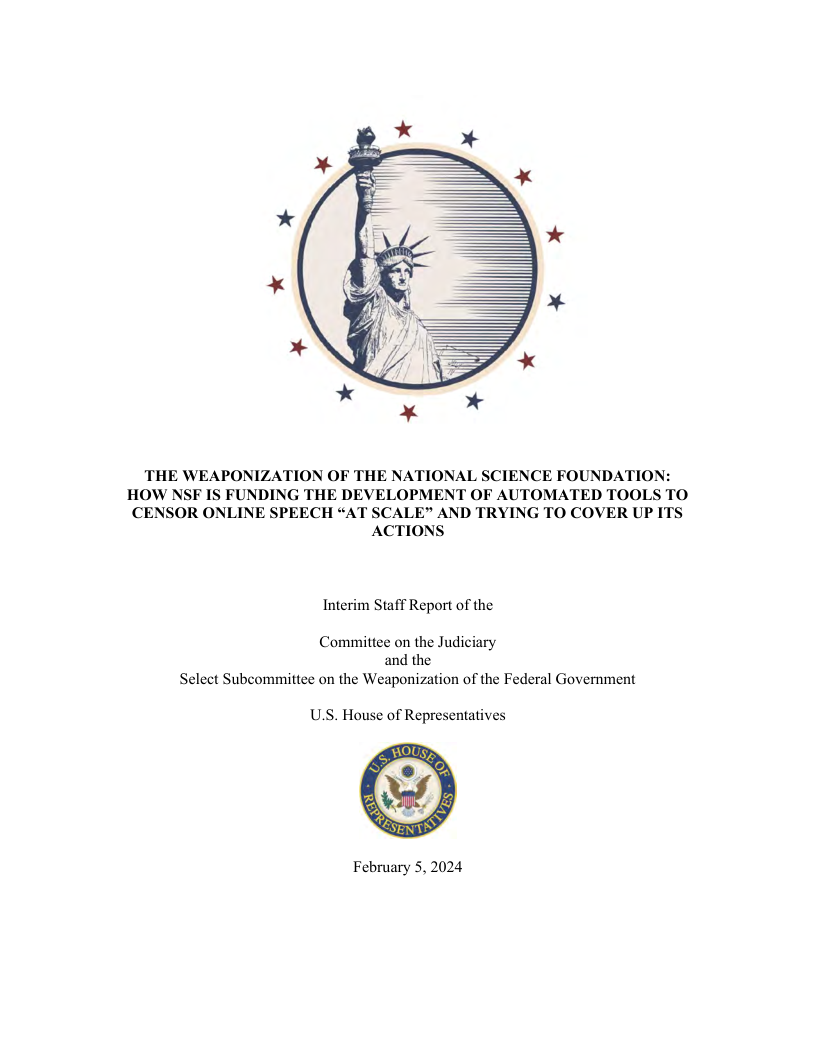

In [14]:
# Read PDF file

filepath = '/Users/karie/Desktop/NSF-Staff-Report_Appendix.pdf'
images = rasterize_paper(pdf=filepath, return_pil=True)
image = Image.open(images[0])
image

In [16]:
# Prepare image for the ML model
pixel_values = processor(images=image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 896, 672])


In [9]:
# Assign device capabilities
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Autoregressively generate tokens, with custom stopping criteria (as defined by the Nougat authors)
outputs = model.generate(pixel_values.to(device),
                          min_length=1,
                          max_length=3584,
                          bad_words_ids=[[processor.tokenizer.unk_token_id]],
                          return_dict_in_generate=True,
                          output_scores=True,
                          stopping_criteria=StoppingCriteriaList([StoppingCriteriaScores()]),
)

In [17]:
# Execute PDF to Text task
generated = processor.batch_decode(outputs[0], skip_special_tokens=True)[0]
generated = processor.post_process_generation(generated, fix_markdown=False)
print(generated)



**THE WEAPONIZATION OF THE NATIONAL SCIENCE FOUNDATION: HOW NSF IS FUNDING THE DEVELOPMENT OF AUTOMATED TOOLS TO CENSOR ONLINE SPEECH "AT SCALE" AND TRYING TO COVER UP ITS Actions**

Interim Staff Report of the

Committee on the Judiciary

and the

Select Subcommittee on the Weaponization of the Federal Government

U.S. House of Representatives
